In [1]:
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris()
X = iris.data[:,[2,3]]
y = iris.target
print('Class Labels:',np.unique(y))

Class Labels: [0 1 2]


In [3]:
## np.unique(y) 将iris的label转化为0,1,2 label形式，减少占用内存。
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 824, stratify = y)
# stratify : array-like, default=None If not None, data is split in a stratified fashion, using this as the class labels. 分层支持，使得能够返回与输入数据集的分类标签相同比例的训练集和测试集
# shuffle默认为True，以打乱数据集防止训练集或测试集出现严重的类别不平衡情形

In [4]:
print('Labels counts in y:',np.bincount(y))
print('Labels count in y_train:',np.bincount(y_train))
print('Labels count in y_test:',np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels count in y_train: [35 35 35]
Labels count in y_test: [15 15 15]


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [6]:
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test) # 使用相同缩放参数缩放测试集数据使得训练数据集与测试数据集的数值具有可比性

In [7]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0 =0.1,random_state = 824)
ppn.fit(X_train_std,y_train)

Perceptron(eta0=0.1, random_state=824)

In [8]:
y_pred = ppn.predict(X_test_std)
print('Misclassified samples:%d'%(y_test != y_pred).sum())

Misclassified samples:6


In [9]:
from sklearn.metrics import accuracy_score
print('Accuracy:%.3f'% ppn.score(X_test_std,y_test))
print('Accuracy:%.3f'% accuracy_score(y_test,y_pred))

Accuracy:0.867
Accuracy:0.867


In [10]:
## Decision Surface
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
def plot_decision_regions(X,y,classifier,resolution = 0.02,test_idx = None):
    # setup marker generator and color map
    markers = ('o','v','s','^','<')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min,x1_max = X[:,0].min() - 1,X[:,0].max() + 1
    x2_min,x2_max = X[:,1].min() - 1,X[:,1].max() + 1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    lab = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1,xx2,lab,alpha = 0.3,cmap = cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())

    # plot the class examples
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl,0],y = X[y == cl,1],alpha = 0.8,c = colors[idx],marker = markers[idx],
                    label = f'class{cl}',edgecolor = 'black')
    # highlight test samples
    if test_idx:
        # plot all examples
        X_test,y_test = X[test_idx,:],y[test_idx]

        plt.scatter(X_test[:,0],X_test[:,1],
                    c = 'none',edgecolor = 'black',
                    alpha = 1.0,
                    linewidth = 1,marker = 'o',
                    s = 100,label = 'Test set')

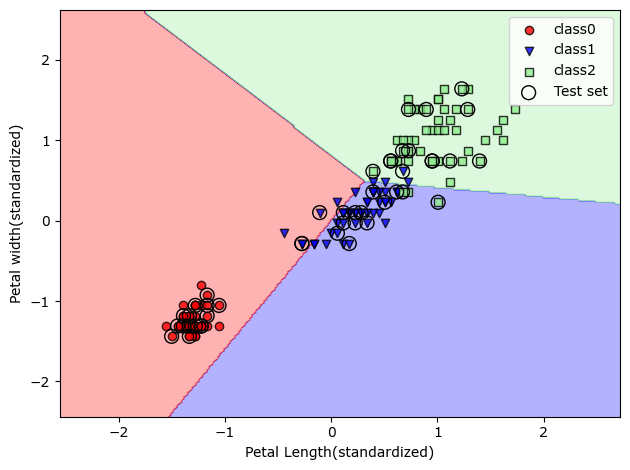

In [11]:
X_combined_std = np.vstack((X_train_std,X_test_std))
y_combined = np.hstack((y_train,y_test))
plot_decision_regions(X_combined_std,y_combined,classifier = ppn,test_idx = range(105,150))
plt.xlabel('Petal Length(standardized)')
plt.ylabel('Petal width(standardized)')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

- 如果数据是线性不可分的，那么perception算法很难达到理想结果且永不会收敛。
- 接下来介绍几个更强大的线性分类器

# Logistic Regression
- 尽管叫做‘Regression’，但其实本质分类器
## 逻辑回归与条件概率
1. 几率(odds):对一个事件发生可能性的度量：$ odds = \frac{p}{1-p}$,其中p是事件发生概率
2. 给定样本特征 $\bf{x}$,$P(y = 1| \bf{x})$表示在给定样本特征为$\bf{x}$情况下，其标签为1的概率
3. Logit函数：$logit(p) = log(\frac{p}{1-p})$,是几率的对数函数
4. logistic regression 假设 net_input 与 Logit 函数存在线性关系：
$logit(p) = \sum_{j = 1}^{m}w_jx_j + b = \mathbf{w^T x} + b $
5. 我们关心的是概率 $p$ ,因此采用 logit 函数的逆函数 sigmoid 将其映射回概率 $p$ :$\sigma(z) = \frac{1}{1+e^{-z}}$,其中$z = \mathbf{w^T x} + b$

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\DELL\AppData\Local\Temp\ipykernel_3484\3591553915.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$ \sigma (z)$')


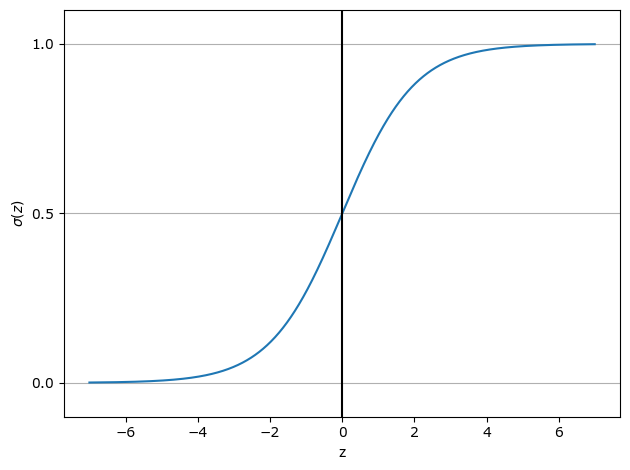

In [12]:
def sigmoid(z):
    return 1/(1+np.exp(-z))
z = np.arange(-7,7,0.01)
sigmoid_z = sigmoid(z)
plt.plot(z,sigmoid_z)
plt.axvline(0.0,color = 'k')
plt.xlabel('z')
plt.ylabel('$ \sigma (z)$')
plt.ylim(-0.1,1.1)
plt.yticks([0.0,0.5,1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

# 使用逻辑损失函数来更新权值
- 似然函数：
$$
L( \mathbf{w},b|\mathbf{x}) = p(y | \mathbf{x;w},b) = \prod_{i = 1}^{n}p(y^{(i)} | \mathbf{x}^{(i)} \mathbf{;w},b) = \prod_{i = 1}^{n} (\sigma(z^{(i)})^{y^{(i)}}(1-\sigma(z^{(i)}))^{1-y^{(i)}}
$$
- 对数似然
$$l( \mathbf{w},b|\mathbf{x}) = log(L( \mathbf{w},b|\mathbf{x})) = \sum_{i=1}^{n}[y^{(i)}log(\sigma(z^{(i)})) + (1 - y^{(i)})log(1 - \sigma(z^{(i)})]
$$
- 目标是最大化似然函数，我们也可以对对数似然取相反数并将其作为损失函数，再用梯度下降法寻找最优参数

In [13]:
def loss_1(z):
    return -np.log(sigmoid(z))
def loss_2(z):
    return -np.log(1-sigmoid(z))

<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
C:\Users\DELL\AppData\Local\Temp\ipykernel_3484\372404449.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma(z)$')


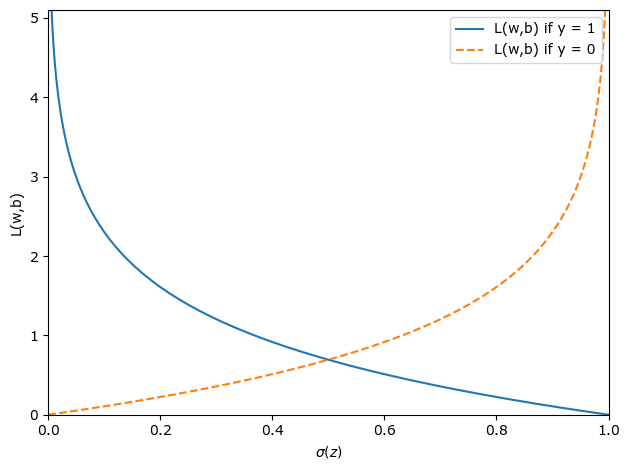

In [14]:
z = np.arange(-10,10,0.1)
sigma_z = sigmoid(z)
c1 = [loss_1(x) for x in z]
c2 = [loss_2(x) for x in z]
plt.plot(sigma_z,c1,label = 'L(w,b) if y = 1')
plt.plot(sigma_z,c2,linestyle = '--',label = 'L(w,b) if y = 0')
plt.ylim(0.0,5.1)
plt.xlim([0,1])
plt.xlabel('$\sigma(z)$')
plt.ylabel('L(w,b)')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

In [15]:
from LogisticRegression import LogisticRegressionGD

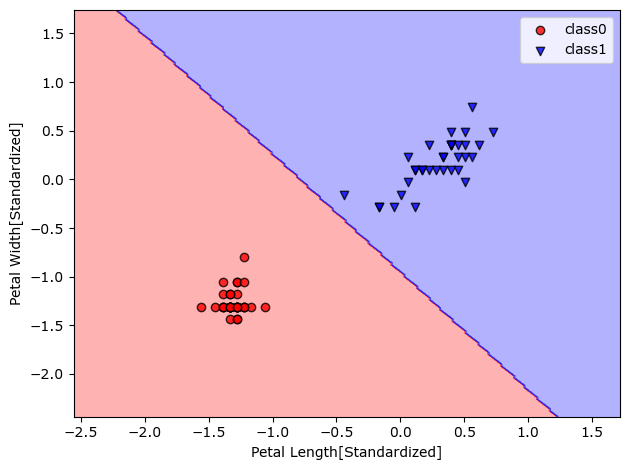

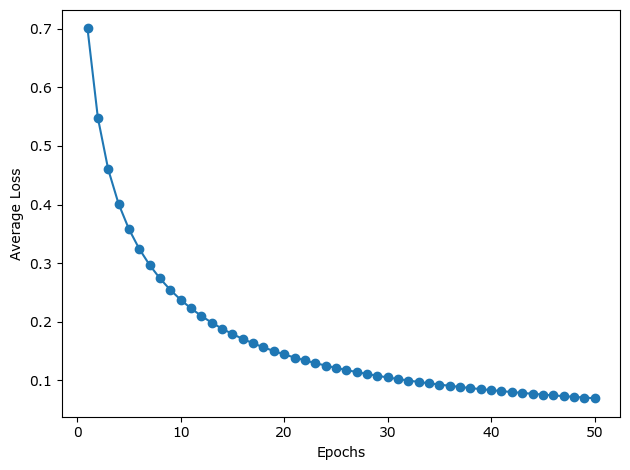

In [16]:
X_train_01_subset = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta = 0.3, n_iter = 50, random_state = 824)
lrgd.fit(X_train_01_subset,y_train_01_subset)
plot_decision_regions(X =X_train_01_subset,y = y_train_01_subset,classifier = lrgd)
plt.xlabel('Petal Length[Standardized]')
plt.ylabel('Petal Width[Standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()
plt.plot(range(1,1 + len(lrgd.losses_)),lrgd.losses_,marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.tight_layout()
plt.show()

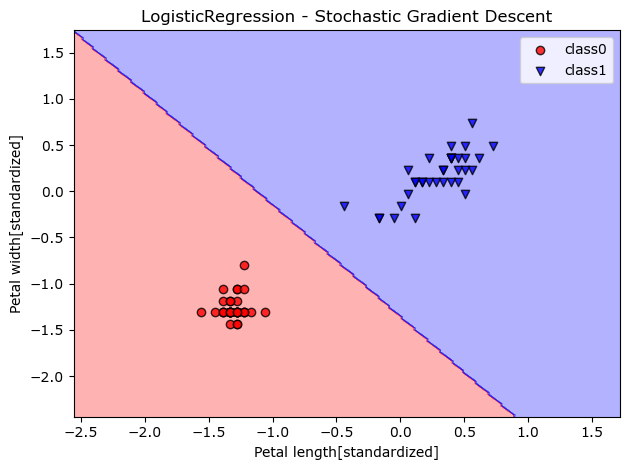

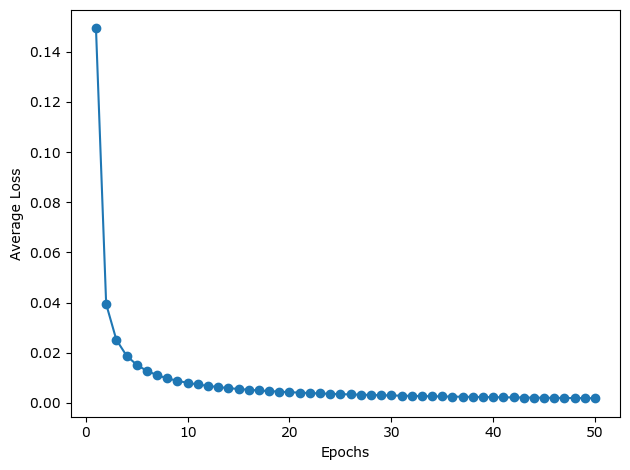

In [17]:
from LogisticRegression import LogisticRegressionSGD
lrsgd = LogisticRegressionSGD(eta = 0.3,n_iter = 50,random_state = 824)
lrsgd.fit(X_train_01_subset,y_train_01_subset)
plot_decision_regions(X_train_01_subset,y_train_01_subset,lrsgd)
plt.title('LogisticRegression - Stochastic Gradient Descent')
plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()
plt.plot(range(1,1 + len(lrsgd.losses_)),lrsgd.losses_,marker = 'o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.tight_layout()
plt.show()

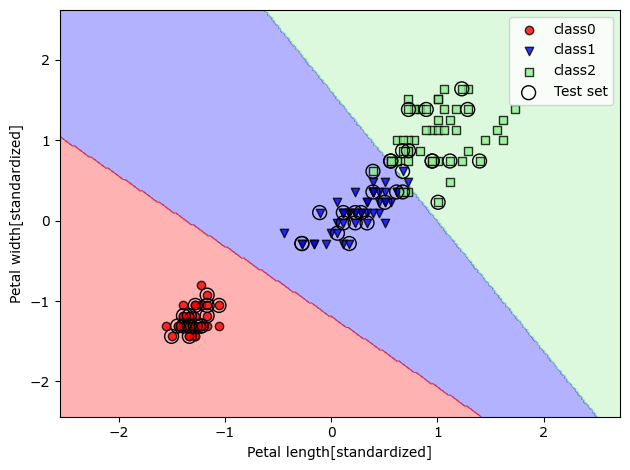

In [18]:
## 这里直接展示用scikit-learn的例子
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 100,solver = 'newton-cg',multi_class = 'multinomial')
lr.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier = lr,test_idx = range(105,150))
plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc = 0)
plt.tight_layout()

# `LogisticRegression` 参数详解

- `penalty`：正则化类型，可选 `l1`, `l2`, `elasticnet`, `none`。注意不同 `solver` 支持的 `penalty` 不同（例如 `liblinear` 支持 `l1`/`l2`，`saga` 支持 `elasticnet`）。
- `dual`：仅对 `penalty='l2'` 且 `solver='liblinear'` 有意义。用于对偶/原问题切换，通常在样本数 < 特征数时用 `dual=True`。
- `tol`：收敛阈值（容忍误差），用于判断优化何时停止（默认较小）。
- `C`：正则化强度的倒数（inverse regularization strength），值越小正则化越强。相当于缩放损失项的系数。
- `fit_intercept`：是否拟合截距项 `b`。
- `intercept_scaling`：仅在 `solver='liblinear'` 且 `fit_intercept=True` 时生效，用于对截距项做缩放（数值技巧）。
- `class_weight`：处理类别不平衡，可设置为 `None`、`balanced` 或字典 `{label: weight}`。
- `random_state`：用于可重复性（如 `sag`/`saga` 等随机优化或多分类时的内部随机化）。
- `solver`：优化算法，常见有：
  - `liblinear`：适合小数据集，支持 `l1`/`l2`（二分类效果好）。
  - `newton-cg`, `lbfgs`：基于二阶近似，支持 `l2`，适合小到中等规模，多分类（multinomial）。
  - `sag`, `saga`：基于随机近似，适合大规模数据；`saga` 支持 `elasticnet`。
- `max_iter`：最大迭代次数，迭代不足会报收敛警告。
- `multi_class`：多类策略，常用 `auto`（自动选择）、`ovr`（一对多）、`multinomial`（整体多项式损失，需支持的 solver）。
- `verbose`：输出训练过程信息（调试用）。
- `warm_start`：是否在已有系数基础上继续训练（可节省搜索多个 `C` 或多次调用的开销）。
- `n_jobs`：并行计算使用的核数（对某些 solver 或多分类交叉验证有用）。
- `l1_ratio`：弹性网混合系数（仅在 `penalty='elasticnet'` 且 `solver='saga'` 时生效），0=>L2，1=>L1。

常见建议：
- 小数据集/二分类：`solver='liblinear'`。
- 多类或需要概率输出且数据中等：`solver='lbfgs'` 或 `newton-cg`。
- 大规模稀疏数据或需要 `elasticnet`：`solver='saga'`。
- 想调正则化强度时通过 `C` 做网格搜索或交叉验证。

# `LogisticRegressionCV`（带交叉验证的 Logistic 回归）说明

用途：在内部对一组候选 `C` 值做交叉验证，自动选择最优 `C`，比手动搜索更方便。

主要参数与含义：
- `Cs`：候选的逆正则化强度序列，既可以给定一个整数（表示默认按对数空间生成若干个 `C`），也可以直接传数组。
- `cv`：交叉验证策略或折数（int 或交叉验证生成器），决定如何划分训练/验证集。
- `scoring`：用于评估性能的指标（例如 `accuracy`、`neg_log_loss` 等），影响最优 `C` 的选择。
- `refit`：是否用选出的最优 `C` 在全部训练集上再拟合最终模型（通常为 True）。
- 其它参数与 `LogisticRegression` 相同：如 `penalty`, `solver`, `class_weight`, `max_iter`, `tol`, `multi_class`, `n_jobs`, `verbose` 等。
- `verbose`/`n_jobs`：用于加速和调试 CV 过程。

重要输出属性（训练后可访问）：
- `Cs_`：实际用于搜索的 `C` 列表（如果输入为 int，会自动生成）。
- `C_`：最终选择的 `C`（对于多分类，返回每个类别的最佳 `C` 或单一值，视 `multi_class` 而定）。
- `coef_`, `intercept_`：最终模型的参数（如果 `refit=True`，是用最优 `C` 在全部训练数据重新拟合的结果）。
- `scores_`：字典，保存每个类别/评分的交叉验证得分（shape 与 `Cs_`、`cv` 相关）。
- `n_iter_`：每次拟合实际迭代次数（不同 `C`/fold 下可能不同）。

使用场景建议：
- 想要自动选择合适正则化强度 `C`，且数据量允许内部做 CV 时使用。
- 若需更复杂的超参数搜索（例如同时搜索 `penalty`、`l1_ratio` 等），可考虑 `GridSearchCV` / `RandomizedSearchCV`。

In [19]:
lr.predict_proba(X_test_std[:4])

array([[1.23776460e-08, 4.01051334e-02, 9.59894854e-01],
       [5.47326276e-06, 7.86301495e-01, 2.13693032e-01],
       [9.99824624e-01, 1.75375812e-04, 3.62018471e-22],
       [9.99386247e-01, 6.13753446e-04, 1.25119876e-20]])

In [20]:
lr.predict_proba(X_test_std[:4]).argmax(axis = 1)

array([2, 1, 0, 0], dtype=int64)

In [21]:
# 预测单一样本
print(lr.predict(X_test_std[-1,:].reshape(1,-1)))
print(X_test_std[-1].shape)
print(X_test_std[-1,:].reshape(1,-1).shape)
# 采用reshape将单一样本的一维数组展开为2维 ，反正reshape(-1,1)是拉平为1-d

[0]
(2,)
(1, 2)


In [22]:
print(lr.predict(X_test_std[-4:-1]).reshape(-1,1))
print(lr.predict(X_test_std[-4:-1]))

[[1]
 [1]
 [2]]
[1 1 2]


## 避免过拟合
- 偏差-方差 tradeoff —— 大方差正比于过拟合，大偏差正比于欠拟合
- 方差的理解：多次训练同一个模型但每次使用同一训练数据集的不同子集，那么方差就用来衡量模型对特定样本分类预测结果的变异性
- 偏差的理解：在不同的训练集上训练同一模型，其预测值离正确值的距离
- 如何降低过拟合？ ——使用正则化技术（L1、L2），即引入额外的信息来惩罚极端参数权值

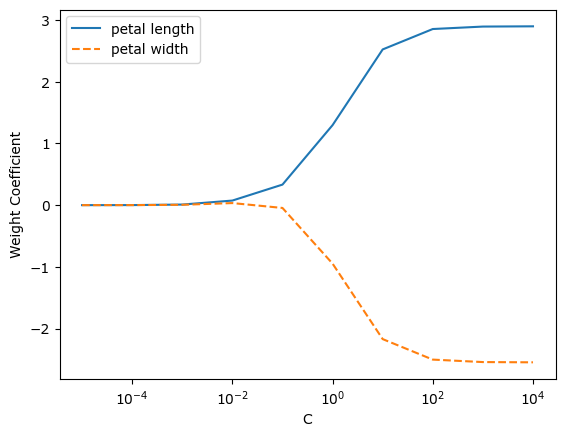

In [23]:
weights,params = [],[]
for c in np.arange(-5,5):
    lr = LogisticRegression(C = 10.**c,multi_class = 'ovr') #C是正则化系数的倒数
    lr.fit(X_train_std,y_train)
    weights.append(lr.coef_[1])
    params.append(10.**c)
weights = np.array(weights)
plt.plot(params,weights[:,0],
         label = 'petal length')
plt.plot(params,weights[:,1],linestyle = '--',
         label = 'petal width')
plt.ylabel('Weight Coefficient')
plt.xlabel('C')
plt.legend(loc = 0)
plt.xscale('log')
plt.show()

In [24]:
## 正则化强度太大的话，参数无限接近于0，拟合能力不足

# SVM
- SVM可以视作为感知机的拓展，感知机目的是为了最小化样本分类错误，支持向量机的目的是最大化分类间隔
![SVM 最大化间隔](SVM.png)
- 在SVM算法中，引入变量C作为松弛变量，控制分离错误的代价，C越大，惩罚程度越大。一般而言，可以用C控制分离间隔的宽度，从而调整方差-偏离平衡
![SVM 参数C](SVM_C.png)


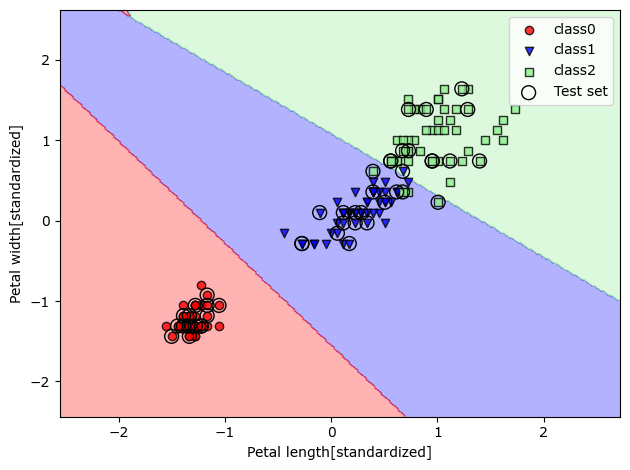

In [25]:
from sklearn.svm import SVC
svm = SVC(kernel = 'linear',C = 1.0,random_state = 824)
svm.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,svm,test_idx = range(105,150))
plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

# SVM 参数与重要属性

## 常用参数
- `C`：正则化参数，控制对违例（margin 之外误差）的惩罚力度。`C` 越大，模型越倾向于把训练样本分对（更小的间隔，可能过拟合）；`C` 越小，间隔越大（可能欠拟合）。
- `kernel`：核函数类型，常见值 `linear`, `poly`, `rbf`, `sigmoid`, 或自定义核。决定模型能否处理非线性边界。
- `degree`：多项式核 `poly` 的次数（多项式阶数）。
- `gamma`：核系数，控制单个训练样本的影响范围。常见取值 `"scale"`、`"auto"` 或具体数值；对 `rbf`/`poly`/`sigmoid` 有重要影响，增加 gamma 可能会导致更严格更颠簸的决策曲线。
- `coef0`：核函数中的常数项，主要影响 `poly` 和 `sigmoid`。
- `shrinking`：是否使用收缩启发式（布尔值），通常能加速训练。
- `probability`：是否启用概率估计（会显著增加训练时间且内部会做额外拟合），若为 `True` 可使用 `predict_proba`。
- `tol`：停止标准的容忍度（收敛阈值）。
- `cache_size`：内核缓存大小（以 MB 为单位）。
- `class_weight`：类别权重，用于处理不平衡数据，可设为 `None`、`'balanced'` 或字典 `{label: weight}`。
- `max_iter`：最大迭代次数，`-1` 表示不限制。
- `verbose`：是否打印训练过程信息（调试用）。
- `random_state`：用于内部随机化（例如概率估计或某些优化细节），保证可复现。
- `decision_function_shape`：多类时决策函数输出形式，`'ovr'` 或 `'ovo'`（`SVC` 的参数）。
- `break_ties`：当 `decision_function_shape='ovr'` 且 `probability=False` 时，是否在预测时打破平局（仅在特定条件下有效）。

## 重要属性（训练后可访问）
- `support_`：支持向量在训练集中的索引数组。
- `support_vectors_`：支持向量坐标数组（形状为 `[n_support_vectors, n_features]`）。
- `n_support_`：每个类别对应的支持向量数量（数组）。
- `dual_coef_`：对偶系数（在二分类或多分类的一对多表示下，形状依 kernel 而异）。
- `coef_`：仅当使用线性核（或 LinearSVC）且模型以适当形式训练时可用，表示原始权重向量（`shape = [n_classes * (n_classes-1)/2, n_features]` 或 `[n_classes, n_features]`，取决于 `decision_function_shape`）。
- `intercept_`：模型的偏置项（截距）。
- `classes_`：训练时的类别标签数组。
- `shape_fit_`（或 `fit` 相关属性）：记录训练输入的形状信息（实现细节，非所有实现都有）。
- `probA_`, `probB_`：当 `probability=True` 时内部用于概率校准的参数（仅在 `SVC` 中出现，通常无需直接修改）。
- `n_iter_` / `fit_status_`：部分实现会提供实际迭代次数或拟合状态/收敛信息（以实现为准）。

## 使用建议
- 对高维稀疏数据，线性核或 LinearSVC 更高效。
- 对复杂非线性边界，常先尝试 `rbf`，再调 `gamma` 与 `C`。
- 若需要概率输出且能接受更长训练时间，设置 `probability=True`。
- 使用 `class_weight='balanced'` 或自定义权重处理类别不平衡。
- 调参时常用交叉验证（`GridSearchCV` / `RandomizedSearchCV`）搜索 `C`、`gamma`、`kernel`（及 `degree`/`coef0`）组合。

## 使用核支持向量机解决非线性问题

In [26]:
np.random.seed(824)
X_xor = np.random.randn(200,2)
y_xor = np.logical_xor(X_xor[:,0] > 0,X_xor[:,1]>0)
y_xor = np.where(y_xor,1,0)

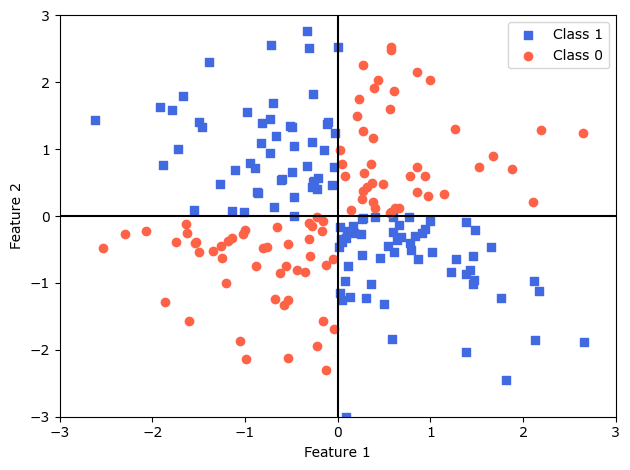

In [27]:
plt.scatter(X_xor[y_xor == 1,0],
            X_xor[y_xor == 1,1],
            c = 'royalblue',marker = 's',
            label = 'Class 1')
plt.scatter(X_xor[y_xor == 0,0],
            X_xor[y_xor == 0,1],
            c = 'tomato',marker = 'o',
            label = 'Class 0')
plt.axvline(0.0,color = 'k')
plt.axhline(0.0,color = 'k')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

- 对于上面的数据集，显然无法使用线性分割器将正负类别区分开
- 我们引入核思想，将原始特征维度投射到一个更高维的空间，如果能在高维空间中线性可分，那么就能找到一个分割使得原始数据可分
- 例如采用变换 $ \phi(x_1,x_2) = (z_1,z_2,z_3) = (x_1,x_2,x_{1}^2 + x_{2}^2)$ 对下面的数据进行变换
![An example](example_kernel.png)
- 思路: 使用映射函数$\phi$ 将训练数据变换到高维特征空间，然后训练一个线性支持向量机模型对高维空间中的数据进行分离
- 核函数 ：衡量样本相似系数，为了避免在投影到高维数据空间后仍用点积表示距离导致消耗巨大内存
- 线性核函数 $$\kappa(x^{(i)},x^{(j)}) = (x^{(i)})^T x^{(j)}$$
- 高斯核 $$\kappa(x^{(i)},x^{(j)}) = e^{-\frac{||x^{(i)} - x^{(j)}||^2}{2\sigma^2}}$$
- sigmoid核 $$ \kappa(x^{(i)},x^{(j)}) = tanh(\beta (x^{(i)})^T x^{(j)} + \theta)$$
- 多项式核 $$\kappa(x^{(i)},x^{(j)}) = ((x^{(i)})^T x^{(j)})^d$$
- Laplace核 $$\kappa(x^{(i)},x^{(j)}) = e^{-\frac{||x^{(i)} - x^{(j)}||}{\sigma}}$$

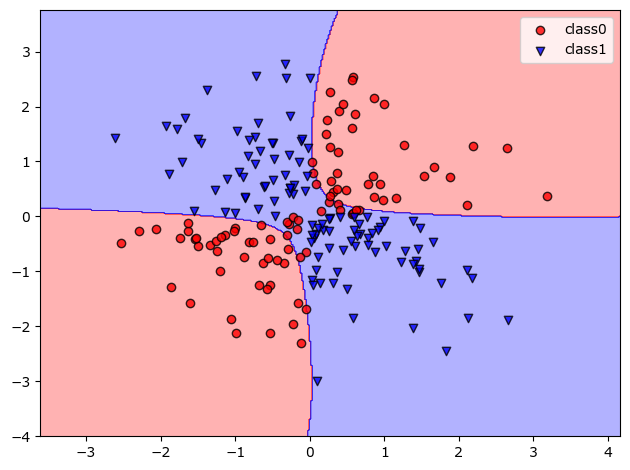

In [28]:
svm = SVC(kernel = 'rbf',gamma = 0.10,C = 10.0,random_state = 824)
svm.fit(X_xor,y_xor)
plot_decision_regions(X_xor,y_xor,svm)
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

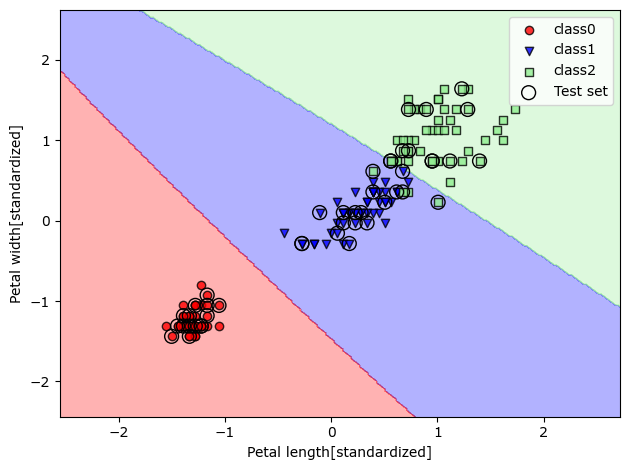

In [29]:
svm = SVC(kernel = 'rbf',C = 1.0,gamma = 0.1,random_state = 824)
svm.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,svm,test_idx = range(105,150))
plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

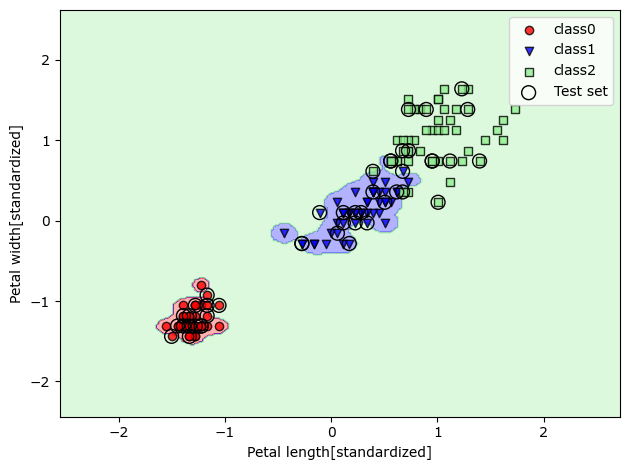

In [30]:
## gamma越大可能导致更颠簸的决策曲线
svm = SVC(kernel = 'rbf',C = 1.0,gamma = 100,random_state = 824)
svm.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,svm,test_idx = range(105,150))
plt.xlabel('Petal length[standardized]')
plt.ylabel('Petal width[standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

# 决策树学习
![决策树基本流程](decisiontree.png)
- 从根节点开始，基于信息增益最大的特征来分裂数据
- 在子节点重复迭代这个过程
- 若子节点所有训练样本标签一致，则这样的节点被称为叶子节点
- 实际中，构建一个子节点众多且层次很深的模型很容易导致过拟合，因此我们一般采用设置决策树的最大深度对其进行修剪

## 最大化信息增益
$$
IG(D_p,f) = I(D_{p}) - \sum_{j = 1}^{n} \frac{N_j}{N_p}I(D_j)
$$
- 这里，f是分裂数据的特征;$D_p$和$D_j$分别是父节点和第j个子节点包含的数据；I为杂志的度量；$N_p$是父节点包含的训练数据样本数；$N_j$是第j个子节点包含训练数据的样本数
- 信息增益是父节点与子节点杂志的差值，子节点杂志含量小，信息增益越大
- 我们规定父节点只被划分为2个子节点，分别为$D_{left}和D_{right}$,于是上式可简化为:
$$
IG(D_{p},f) = I(D_p) - \frac{N_{left}}{N_p}I(D_{left}) = \frac{N_{right}}{N_p}I(D_{right})
$$

## 三种杂质度量
1. 熵 $I_H$ :
$$I_H(t) = -\sum_{i = 1}^{c}p(i | t)log_2p(i | t)$$
$p(i|t)$ 是节点 $t$ 中训练样本属于类别i的概率；注意所有样本均属于同一类时，熵最小为0；所有样本均匀分布在所有类别时，熵最大
2. 基尼杂质(最小化分类错误):
$$I_G(t) = -\sum_{i = 1}^{c}p(i | t)(1-p(i | t)) = 1 -\sum_{i = 1}^{c} p(i | t)^2$$
基尼杂质与熵杂质产生的结果相似，因此实践中不值得更换杂质评价标准评估决策树，而应该尝试不同的修枝方法
3. 分类误差:
$$I_E(t) = 1 - max[p(i | t)]$$
 分类误差是修剪决策树的有用标准，但通常不建议用于构建决策树，因为其对于节点类别概率变化不敏感

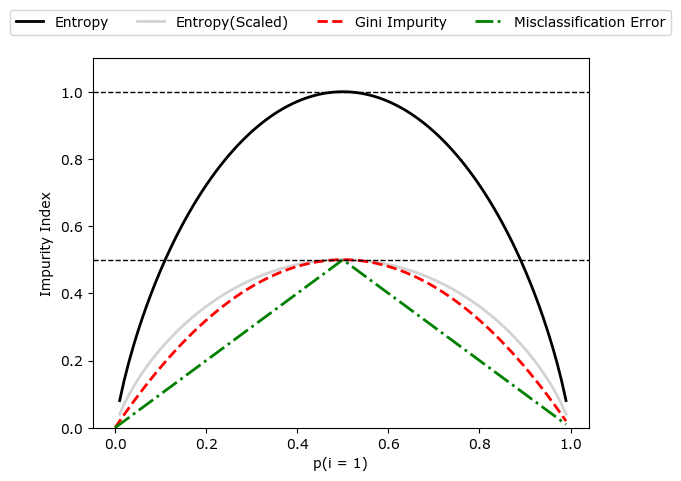

In [41]:
def gini(p):
    return 1 - p**2 - (1-p)**2
def entropy(p):
    return -p * np.log2(p) - (1-p) * np.log2(1-p)
def error(p):
    return 1-np.max([p,1-p])
x = np.arange(0,1,0.01)
ent = [entropy(t) if t!=0 else None for t in x]
sc_ent = [e/2  if e else None for e in ent]
err = [error(t) for t in x]
fig = plt.figure()
ax = plt.subplot(111)
for i,lab,ls,c in zip([ent,sc_ent,gini(x),err],
                      ['Entropy','Entropy(Scaled)','Gini Impurity','Misclassification Error'],
                      ['-','-','--','-.'],
                      ['black','lightgray','red','green','cyan']):
    line = ax.plot(x,i,label = lab,linestyle = ls,lw = 2,color = c)
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5,1.15),ncol = 5,fancybox = True,shadow = False)
ax.axhline(0.5,linewidth = 1,color = 'k',linestyle = '--')
ax.axhline(1,linewidth = 1,color = 'k',linestyle = '--')
plt.ylim([0,1.1])
plt.xlabel('p(i = 1)')
plt.ylabel('Impurity Index')
plt.show()

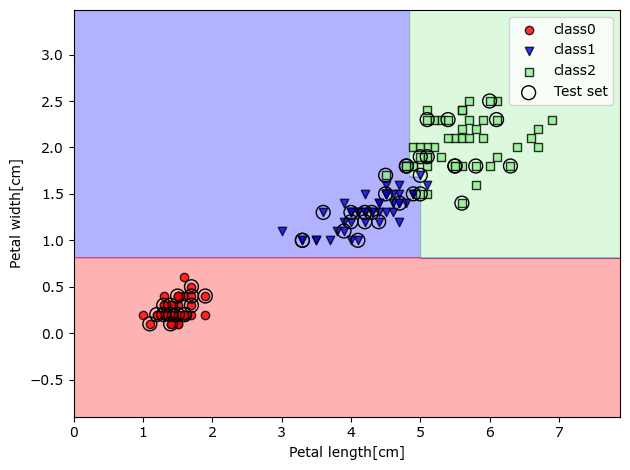

In [43]:
from sklearn.tree import DecisionTreeClassifier
tree_model = DecisionTreeClassifier(max_depth = 4,criterion = 'gini',random_state = 824)
tree_model.fit(X_train,y_train)
X_combined = np.vstack((X_train,X_test))
y_combined = np.hstack((y_train,y_test))
plot_decision_regions(X_combined,y_combined,
                      classifier = tree_model,
                      test_idx = range(105,150))
plt.xlabel('Petal length[cm]')
plt.ylabel('Petal width[cm]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

# DecisionTreeClassifier 参数与返回值

## 常用参数
- `criterion`：分裂质量衡量，常见
`'gini'`
或
`'entropy'`（信息增益）。
- `splitter`：划分策略，`'best'`
或
`'random'`。
- `max_depth`：树的最大深度（None
表示直到叶子纯或样本不足为止）。
- `min_samples_split`：内部节点再划分所需的最小样本数（int
或
float）。
- `min_samples_leaf`：叶子节点所需的最小样本数（int
或
float）。
- `min_weight_fraction_leaf`：叶子节点所需样本权重的最小占比。
- `max_features`：每次分裂考虑的最大特征数（int、float、`'sqrt'`、`'log2'`
或
None）。
- `max_leaf_nodes`：最大叶子节点数（用于限制树的复杂度）。
- `min_impurity_decrease`：节点划分所需的最小不纯度减少。
- `class_weight`：类别权重，`None`、`'balanced'`
或字典。
- `random_state`：随机种子（影响
`splitter = 'random'
` 等）。
- `ccp_alpha`：后剪枝的复杂度惩罚参数（cost - complexity
pruning）。

## 拟合/方法的返回值与重要属性
- `fit(X, y)`：返回
`self`（已拟合模型）。
- `predict(X)`：返回形状为
`(n_samples,)`
的预测标签数组。
- `predict_proba(X)`：返回形状为
`(n_samples, n_classes)`
的类概率（若支持）。
- `predict_log_proba(X)`：返回对数概率。
- `decision_path(X)`：返回稀疏矩阵，表示样本经过的节点路径。
- `apply(X)`：返回每个样本对应的叶子节点索引，形状
`(n_samples,)`。
- `score(X, y)`：返回浮点数（默认
accuracy）。

重要训练后属性（可视为“返回值”/ 模型信息）：
- `classes_`：训练时的类别标签数组。
- `n_classes_`：每个输出的类别数（若多输出则为数组）。
- `n_features_in_`：拟合时输入特征数。
- `n_outputs_`：输出的数量（单输出为
1）。
- `feature_importances_`：特征重要性数组，长度为
`n_features_in_`。
- `tree_`：底层
`Tree`
对象（包含节点结构、阈值、左右子节点索引等），用于高级访问与可视化。
- `max_depth_` / `n_leaves_`（视实现可用）：拟合后实际的最大深度与叶子数。


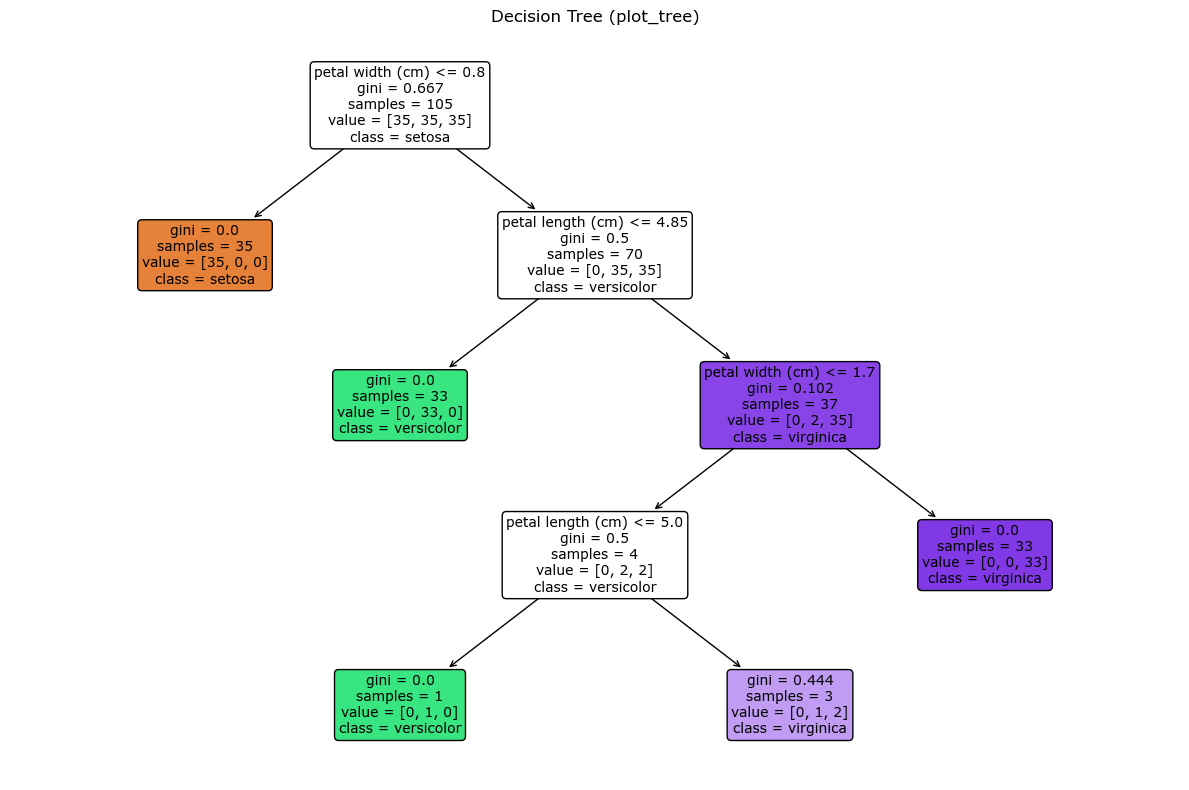

In [49]:
from sklearn import tree as sktree
feature_names = [iris.feature_names[i] for i in [2, 3]]
class_names = iris.target_names
plt.figure(figsize=(12, 8))
sktree.plot_tree(
    tree_model,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title('Decision Tree (plot_tree)')
plt.tight_layout()
plt.show()

# 代价复杂度剪枝（Cost\-Complexity Pruning, CCP）

## 原理
- 通过最小化目标 $R_{\alpha}(T)=R(T)+\alpha|T|$ 来权衡不纯度 $R(T)$ 与树的复杂度 $|T|$（叶子节点数）。
- 参数 ccp_alpha 控制惩罚强度：$\alpha$ 越大，惩罚越强，最终得到越小的树。

## 在 scikit\-learn 中的实现
- 使用 `DecisionTreeClassifier().cost_complexity_pruning_path(X, y)` 可得到一系列候选的 `ccp_alpha` 与对应的 impurity（从不剪到极端剪枝）。
- 对每个候选 `ccp_alpha` 训练一棵树，使用验证集或交叉验证选择使泛化性能最好的 $\alpha$。

## 常见工作流程
1. 在训练子集上计算 `cost_complexity_pruning_path`。
2. 对候选的每个 `ccp_alpha` 分别拟合决策树并在验证集或 CV 上评估。
3. 选择验证性能最好的 `ccp_alpha`（或在 CV 上选择），用该 $\alpha$ 在整个训练集上重拟合最终模型。
4. 在测试集上报告最终性能。

## 注意事项与建议
- `ccp_alpha=0` 表示不剪枝（保留完全树）。
- `ccp_alphas` 中可能包含重复或非常接近的值，可做 `np.unique` 或在对数尺度上取网格以减少训练次数。
- 推荐使用交叉验证或独立验证集来选择 $\alpha$，避免单次划分带来的波动。
- 对小样本或极不平衡数据，剪枝路径和最优 $\alpha$ 可能不稳定，需谨慎解释。
- 若需要更稳定的选择，可把 `ccp_alpha` 作为超参数给 `GridSearchCV`/`RandomizedSearchCV` 进行 CV 搜索。


最佳 ccp_alpha = 0.000000, 验证集准确率 = 1.0000
测试集准确率 = 0.8889
最终树节点数 = 13, 叶子数 = 7


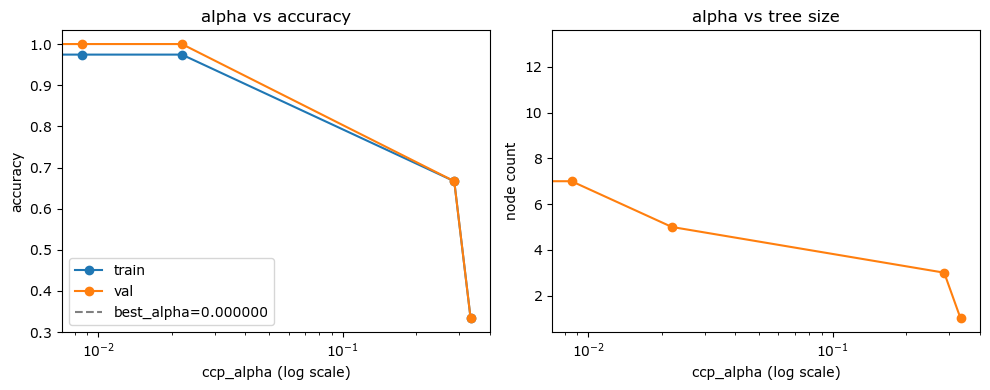

In [59]:

from sklearn.metrics import accuracy_score

# 1) 基于已有的 X_train,y_train 再划分出子训练集和验证集
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=824, stratify=y_train
)  # 现在大致为 60% train / 20% val / 20% test

# 2) 计算 pruning path（在子训练集上）
base_clf = DecisionTreeClassifier(random_state=824)
path = base_clf.cost_complexity_pruning_path(X_subtrain, y_subtrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
# 去重并保证按升序（scikit-learn 返回已排序的 alpha）
ccp_alphas = np.unique(ccp_alphas)

# 3) 对每个 alpha 拟合决策树并记录训练/验证准确率以及节点数
clfs = []
train_scores = []
val_scores = []
node_counts = []
for a in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=824, ccp_alpha=a)
    clf.fit(X_subtrain, y_subtrain)
    clfs.append(clf)
    train_scores.append(accuracy_score(y_subtrain, clf.predict(X_subtrain)))
    val_scores.append(accuracy_score(y_val, clf.predict(X_val)))
    node_counts.append(clf.tree_.node_count)

train_scores = np.array(train_scores)
val_scores = np.array(val_scores)
node_counts = np.array(node_counts)

# 4) 选择在验证集上表现最好的 alpha（如有多个取第一个）
best_idx = np.argmax(val_scores)
best_alpha = ccp_alphas[best_idx]
print(f"最佳 ccp_alpha = {best_alpha:.6f}, 验证集准确率 = {val_scores[best_idx]:.4f}")

# 5) 用最佳 alpha 在训练+验证上重拟合最终模型，并在测试集上评估
X_train_combined = np.vstack((X_subtrain, X_val))
y_train_combined = np.hstack((y_subtrain, y_val))
final_clf = DecisionTreeClassifier(random_state=824, ccp_alpha=best_alpha)
final_clf.fit(X_train_combined, y_train_combined)
test_acc = accuracy_score(y_test, final_clf.predict(X_test))
print(f"测试集准确率 = {test_acc:.4f}")
print(f"最终树节点数 = {final_clf.tree_.node_count}, 叶子数 = {final_clf.get_n_leaves()}")

# 6) 可视化：alpha vs accuracy，以及 alpha vs 节点数（alpha 常用 log scale）
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(ccp_alphas, train_scores, marker='o', label='train')
plt.plot(ccp_alphas, val_scores, marker='o', label='val')
plt.axvline(best_alpha, color='grey', linestyle='--', label=f'best_alpha={best_alpha:.6f}')
plt.xscale('log')
plt.xlabel('ccp_alpha (log scale)')
plt.ylabel('accuracy')
plt.legend()
plt.title('alpha vs accuracy')

plt.subplot(1,2,2)
plt.plot(ccp_alphas, node_counts, marker='o', color='tab:orange')
plt.xscale('log')
plt.xlabel('ccp_alpha (log scale)')
plt.ylabel('node count')
plt.title('alpha vs tree size')

plt.tight_layout()
plt.show()

# 多棵决策树构成随机森林
- 原理：对多棵具有较大方差的决策树进行平均，从而构建出一个更稳健的模型

## 构建随机森林的步骤
1. 使用bootstrap方法从训练数据中抽取n个样本（bootstrap抽取方法从训练数据集中有放回地随机抽取样本）
2. 使用上述抽取的样本训练一棵决策树,在每个节点上：
- a. 不放回地随机选取d个特征
- b. 根据目标函数的要求，例如最大化信息增益，选取最佳特征分裂节点
3. 重复1和2 k 次。
4. 给定一个样本，收集每棵决策树对这个样本的预测标签，投票法最终确定预测标签。

## 随机森林 VS 决策树
1. 解释性上决策树更好，但随机森林不必担心超参数的选择
2. 随机森林通常不需要对其中的决策树进行修剪，因为其对于单棵决策树的噪声具有较强的稳健性
3. 实践中，可能唯一需要关心的超参数是决策树的数量 k
4. 实践中不太常见，但也可以对于 bootstrap 抽取的样本数量以及随机抽取的特征数 d 进行优化。scikit-learn中一般默认抽取原始训练数据集中训练样本个数的样本，$d = \sqrt{m}$，m 是训练数据集中特征总数。


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:    0.0s finished


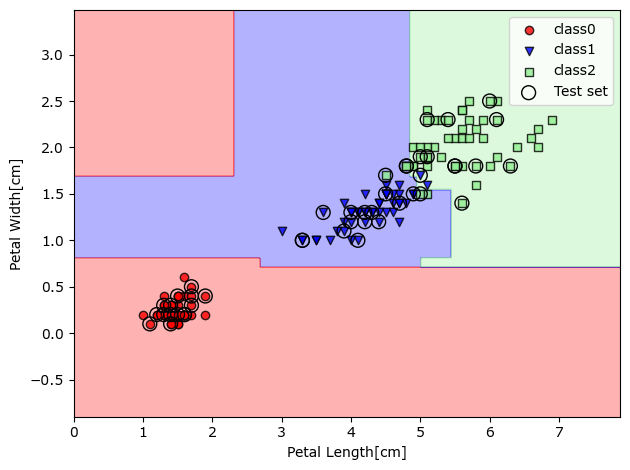

In [58]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 25,
                                criterion = 'entropy',
                                max_depth = 3,
                                random_state = 824,
                                n_jobs = 2,
                                verbose = True)
forest.fit(X_train,y_train)
plot_decision_regions(X_combined,y_combined,classifier = forest,test_idx = range(105,150))
plt.xlabel("Petal Length[cm]")
plt.ylabel('Petal Width[cm]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()

# RandomForestClassifier 参数与返回值

## 常用参数
- `n_estimators`：森林中树的数量（int，默认 100）。
- `criterion`：分裂质量衡量，分类常用 `'gini'` 或 `'entropy'`。
- `max_depth`：每棵树的最大深度（int 或 `None`）。
- `min_samples_split`：内部节点再划分所需的最小样本数（int 或 float）。
- `min_samples_leaf`：叶子节点所需的最小样本数（int 或 float）。
- `min_weight_fraction_leaf`：叶子节点所需样本权重的最小占比。
- `max_features`：每次分裂考虑的最大特征数（int、float、`'sqrt'`、`'log2'` 或 `None`，分类默认 `'sqrt'`）。
- `max_leaf_nodes`：最大叶子节点数（用于限制树的复杂度）。
- `min_impurity_decrease`：节点划分所需的最小不纯度减少。
- `bootstrap`：是否使用 bootstrap 抽样训练每棵树（布尔值，默认 `True`）。
- `oob_score`：是否使用袋外样本估计泛化分数（布尔值）。
- `n_jobs`：并行运行的作业数（`-1` 表示使用所有核）。
- `random_state`：随机种子，用于可复现性。
- `class_weight`：类别权重，`None`、`'balanced'` 或字典。
- `verbose`：训练过程输出详细程度。
- `warm_start`：是否在已有模型基础上添加更多树（布尔值）。
- `ccp_alpha`：后剪枝的复杂度惩罚参数（cost-complexity pruning）。

## 重要方法返回值 / 训练后属性
- `fit(X, y)`：返回 `self`（已拟合模型）。
- `predict(X)`：返回形状为 `(n_samples,)` 的预测标签数组。
- `predict_proba(X)`：返回形状为 `(n_samples, n_classes)` 的类概率。
- `predict_log_proba(X)`：返回对数概率。
- `score(X, y)`：返回浮点数（默认 accuracy）。
- `estimators_`：由训练得到的基础估计器列表（每个通常为 `DecisionTreeClassifier`）。
- `n_estimators_`：实际使用的树数量（拟合后可用）。
- `classes_`：训练时的类别标签数组。
- `n_classes_`：每个输出的类别数（若多输出则为数组）。
- `n_features_in_`：拟合时输入特征数。
- `n_outputs_`：输出数量（单输出为 1）。
- `feature_importances_`：特征重要性数组，长度为 `n_features_in_`。
- `oob_score_`：若 `oob_score=True`，表示袋外估计的分数（浮点数）。
- `oob_decision_function_` / `oob_prediction_`：袋外样本的预测/决策函数（若启用）。
- `estimators_features_` / `estimators_samples_`（实现细节）：记录每棵树使用的样本或特征（视版本而定）。

## 使用建议（简短）
- 增加 `n_estimators` 通常能提升性能但增加计算开销；可以并行 (`n_jobs=-1`) 加速。
- 默认 `max_features='sqrt'` 对分类问题通常是合理选择；可通过交叉验证调优 `max_features`、`max_depth`、`min_samples_leaf`。
- 若需要快速估计泛化性能，可启用 `oob_score=True`。
- 为可复现设置 `random_state`。

# 基于惰性学习策略的 k 近邻算法
- k 近邻之所以被称为惰性算法，是因为 k 近邻算法并不从训练数据中学习分类函数，而仅仅是记住训练数据集
1. 选择 k 的值和一个距离度量
2. 在训练数据集上得到待分类样本的 k 个近邻
3. 为 k 个近邻的标签进行投票，投票结果作为待分类样本的预测标签
- k 近邻算法很容易因为“维度灾难”导致过拟合。“维度灾难”是指特征维数增加，样本空间越来越稀疏。越高维空间中，即便最近的邻值，两者距离也非常远。

![k-nearest](knn.png)

# 参数与非参数模型
- 参数模型是从训练数据中估计参数学习一个分类器，可以对新数据点进行分类而不再需要原始训练数据集。 eg.Perceptron , Linear SVM , LogisticRegression
- 非参数模型不能用一组固定的参数来描述，模型参数的数量随着训练数据的增加而变化 eg. DecisionTreeClassifier , RandomForestClassifier , kernel-supported SVM


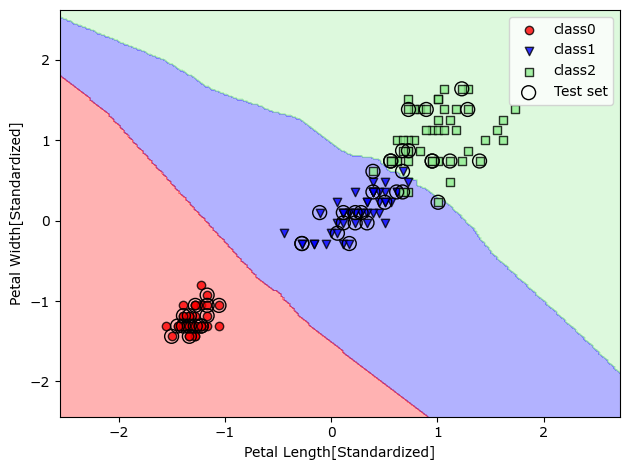

In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5,
                           p = 2,
                           metric = 'minkowski')
knn.fit(X_train_std,y_train)
plot_decision_regions(X_combined_std,y_combined,classifier = knn,test_idx = range(105,150))
plt.xlabel("Petal Length[Standardized]")
plt.ylabel('Petal Width[Standardized]')
plt.legend(loc = 0)
plt.tight_layout()
plt.show()